In [60]:
import gensim
import logging
from gensim.models import word2vec
import networkx as nx
import random

In [48]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Я выбрала семантическе поле horror и нашла список английских слов его характеризующих.

In [49]:
import PyPDF2

In [50]:
article = PyPDF2.PdfFileReader(open('Classic-Horror-Vocabulary.pdf', 'rb'))

In [51]:
text = ''
for i in range(article.getNumPages()):
    page = article.getPage(i)
    text += page.extractText()

Так как по заданию слова должны быть одной частью речи, нужно их распарсить и удалить лишние.

In [52]:
import nltk

In [53]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [54]:
text_token = nltk.word_tokenize(text.lower())
tagged_text = nltk.pos_tag(text_token)[:-4]

[('abomination', 'NN'), ('agony', 'NN'), ('ash', 'NN'), ('banished', 'VBD'), ('barren', 'JJ'), ('black', 'JJ'), ('blade', 'NN'), ('blood', 'NN'), ('bones', 'NNS'), ('burning', 'VBG'), ('caged', 'JJ'), ('calamity', 'NN'), ('careless', 'NN'), ('cast', 'VBD'), ('out', 'RP'), ('chill', 'NN'), ('clammer', 'NN'), ('clammy', 'NN'), ('clawed', 'VBD'), ('cloven', 'JJ'), ('clutch', 'NN'), ('cold', 'NN'), ('condem', 'NN'), ('contempt', 'NN'), ('convulse', 'JJ'), ('crackle', 'NN'), ('crazed', 'VBN'), ('creak', 'JJ'), ('creepy', 'NN'), ('crevice', 'NN'), ('crow', 'NN'), ('cruel', 'NN'), ('crumbling', 'VBG'), ('curl', 'NNS'), ('cursed', 'VBD'), ('curve', 'NN'), ('cut', 'NN'), ('dagger', 'NN'), ('damned', 'VBD'), ('damp', 'JJ'), ('dark', 'NN'), ('deadly', 'RB'), ('death', 'NN'), ('decay', 'NN'), ('decieve', 'VBP'), ('demonic', 'JJ'), ('depress', 'NN'), ('despair', 'NN'), ('despondent', 'JJ'), ('dilapidate', 'NN'), ('dire', 'NN'), ('discarded', 'VBD'), ('doom', 'NN'), ('dread', 'NN'), ('drip', 'NN'), 

In [534]:
nouns = []
for word in tagged_text:
    if 'NN' in word[1]:
        nouns.append(word[0])

Строим первый узел.

In [618]:
sem_field = nx.Graph()
first_word = random.choice(nouns)
sem_field.add_node(first_word)
print('Первый узел:', first_word)

Первый узел: monster


Находим ближайших соседей для этих узлов из модели GloVe.

In [68]:
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-300")

2019-05-31 17:34:28,113 : INFO : Creating C:\Users\Mi\gensim-data


[==================================================] 100.0% 376.1/376.1MB downloaded


2019-05-31 17:44:39,908 : INFO : glove-wiki-gigaword-300 downloaded
2019-05-31 17:44:39,946 : INFO : loading projection weights from C:\Users\Mi\gensim-data\glove-wiki-gigaword-300\glove-wiki-gigaword-300.gz
2019-05-31 17:44:39,950 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-31 17:48:24,942 : INFO : loaded (400000, 300) matrix from C:\Users\Mi\gensim-data\glove-wiki-gigaword-300\glove-wiki-gigaword-300.gz


In [559]:
d_1 = {}
for word in sem_field.nodes():
    if word not in model:
        continue
    d_1[word] = []
    i = 10
    similar = model.most_similar(positive=[word], topn=i)
    while similar[-1][1] >= 0.5:
        i += 10
        similar = model.most_similar(positive=[word], topn=i)
    for neighbor in similar:
        pos = nltk.pos_tag([neighbor[0]])
        if (neighbor[1] >= 0.5) and ('NN' in pos[0][1]):
            d_1[word].append(neighbor)

for word, neighbors in d_1.items():
    for neighbor in neighbors:
        sem_field.add_node(neighbor[0])
        sem_field.add_edge(word, neighbor[0], weight=neighbor[1])
        i = 10
        similar_neighbor = model.most_similar(positive=[neighbor[0]], topn=i)
        while similar_neighbor[-1][1] >= 0.5:
            i += 10
            similar_neighbor = model.most_similar(positive=[neighbor[0]], topn=i)
        for neighbor_neighbor in similar_neighbor:
            pos = nltk.pos_tag([neighbor_neighbor[0]])
            if (neighbor_neighbor[1]) >= 0.5 and ('NN' in pos[0][1]):
                sem_field.add_node(neighbor_neighbor[0])
                sem_field.add_edge(neighbor[0], neighbor_neighbor[0], weight=neighbor_neighbor[1])

In [575]:
print('Количество узлов в графе:', len(sem_field.nodes()))

Количество узлов в графе: 25


Различные центральные узлы:

In [561]:
centr = nx.eigenvector_centrality(sem_field)
eigenvector_node = sorted(centr, key=centr.get, reverse=True)
print('Топ-3 узла по eigencentrality:', ", ".join(eigenvector_node[:3]))

Топ-3 узла по eigencentrality: creature, monsters, beast


In [562]:
centr = nx.closeness_centrality(sem_field)
closeness_node = sorted(centr, key=centr.get, reverse=True)
print('Топ-3 узла по closeness centrality:', ", ".join(closeness_node[:3]))

Топ-3 узла по closeness centrality: monsters, creature, monster


In [563]:
centr = nx.betweenness_centrality(sem_field)
betweenness_node = sorted(centr, key=centr.get, reverse=True)
print('Топ-3 узла по betweenness centrality:', ", ".join(betweenness_node[:3]))

Топ-3 узла по betweenness centrality: monster, monsters, creature


In [564]:
centr = nx.degree_centrality(sem_field)
degree_node = sorted(centr, key=centr.get, reverse=True)
print('Топ-3 узла по degree centrality:', ", ".join(degree_node[:3]))

Топ-3 узла по degree centrality: monsters, creature, beast


Другие свойства графа:

In [565]:
if nx.is_connected(sem_field):
    print('Радиус графа:', nx.radius(sem_field))

if nx.is_connected(sem_field):
    print('Диаметр графа:', nx.diameter(sem_field))

print('Коэффициент ассортативности:', nx.degree_pearson_correlation_coefficient(sem_field))

print('Плотность графа:', nx.density(sem_field))

print('Коэффициент кластеризации:', nx.average_clustering(sem_field))


Радиус графа: 2
Диаметр графа: 4
Коэффициент ассортативности: -0.4976754483063981
Плотность графа: 0.11
Коэффициент кластеризации: 0.19960173160173159


Сообщества:

In [ ]:
from networkx.algorithms import community

In [566]:
coms = community.greedy_modularity_communities(sem_field)

In [567]:
# нужно объединить все выбросы (сообщества с 1 элементом) в одно сообщество
others = set()
others_set = set()
for com in coms:
    if len(com) < 2:
        others.add(com)
if len(others) != 0:
    for com in others:
        coms.remove(com)
        for i in com:
            others_set.add(i)
    coms.append(frozenset(others_set))

In [568]:
print('Количество сообществ:', len(coms))

Количество сообществ: 6


In [569]:
# генерируем цвета для сообществ
import seaborn as sns
colors = {}
color_list = sns.color_palette("cubehelix", n_colors=len(coms)).as_hex()
for n, com in enumerate(coms):
    for word in com:
        colors[word] = color_list[n]

Визуализация графа:

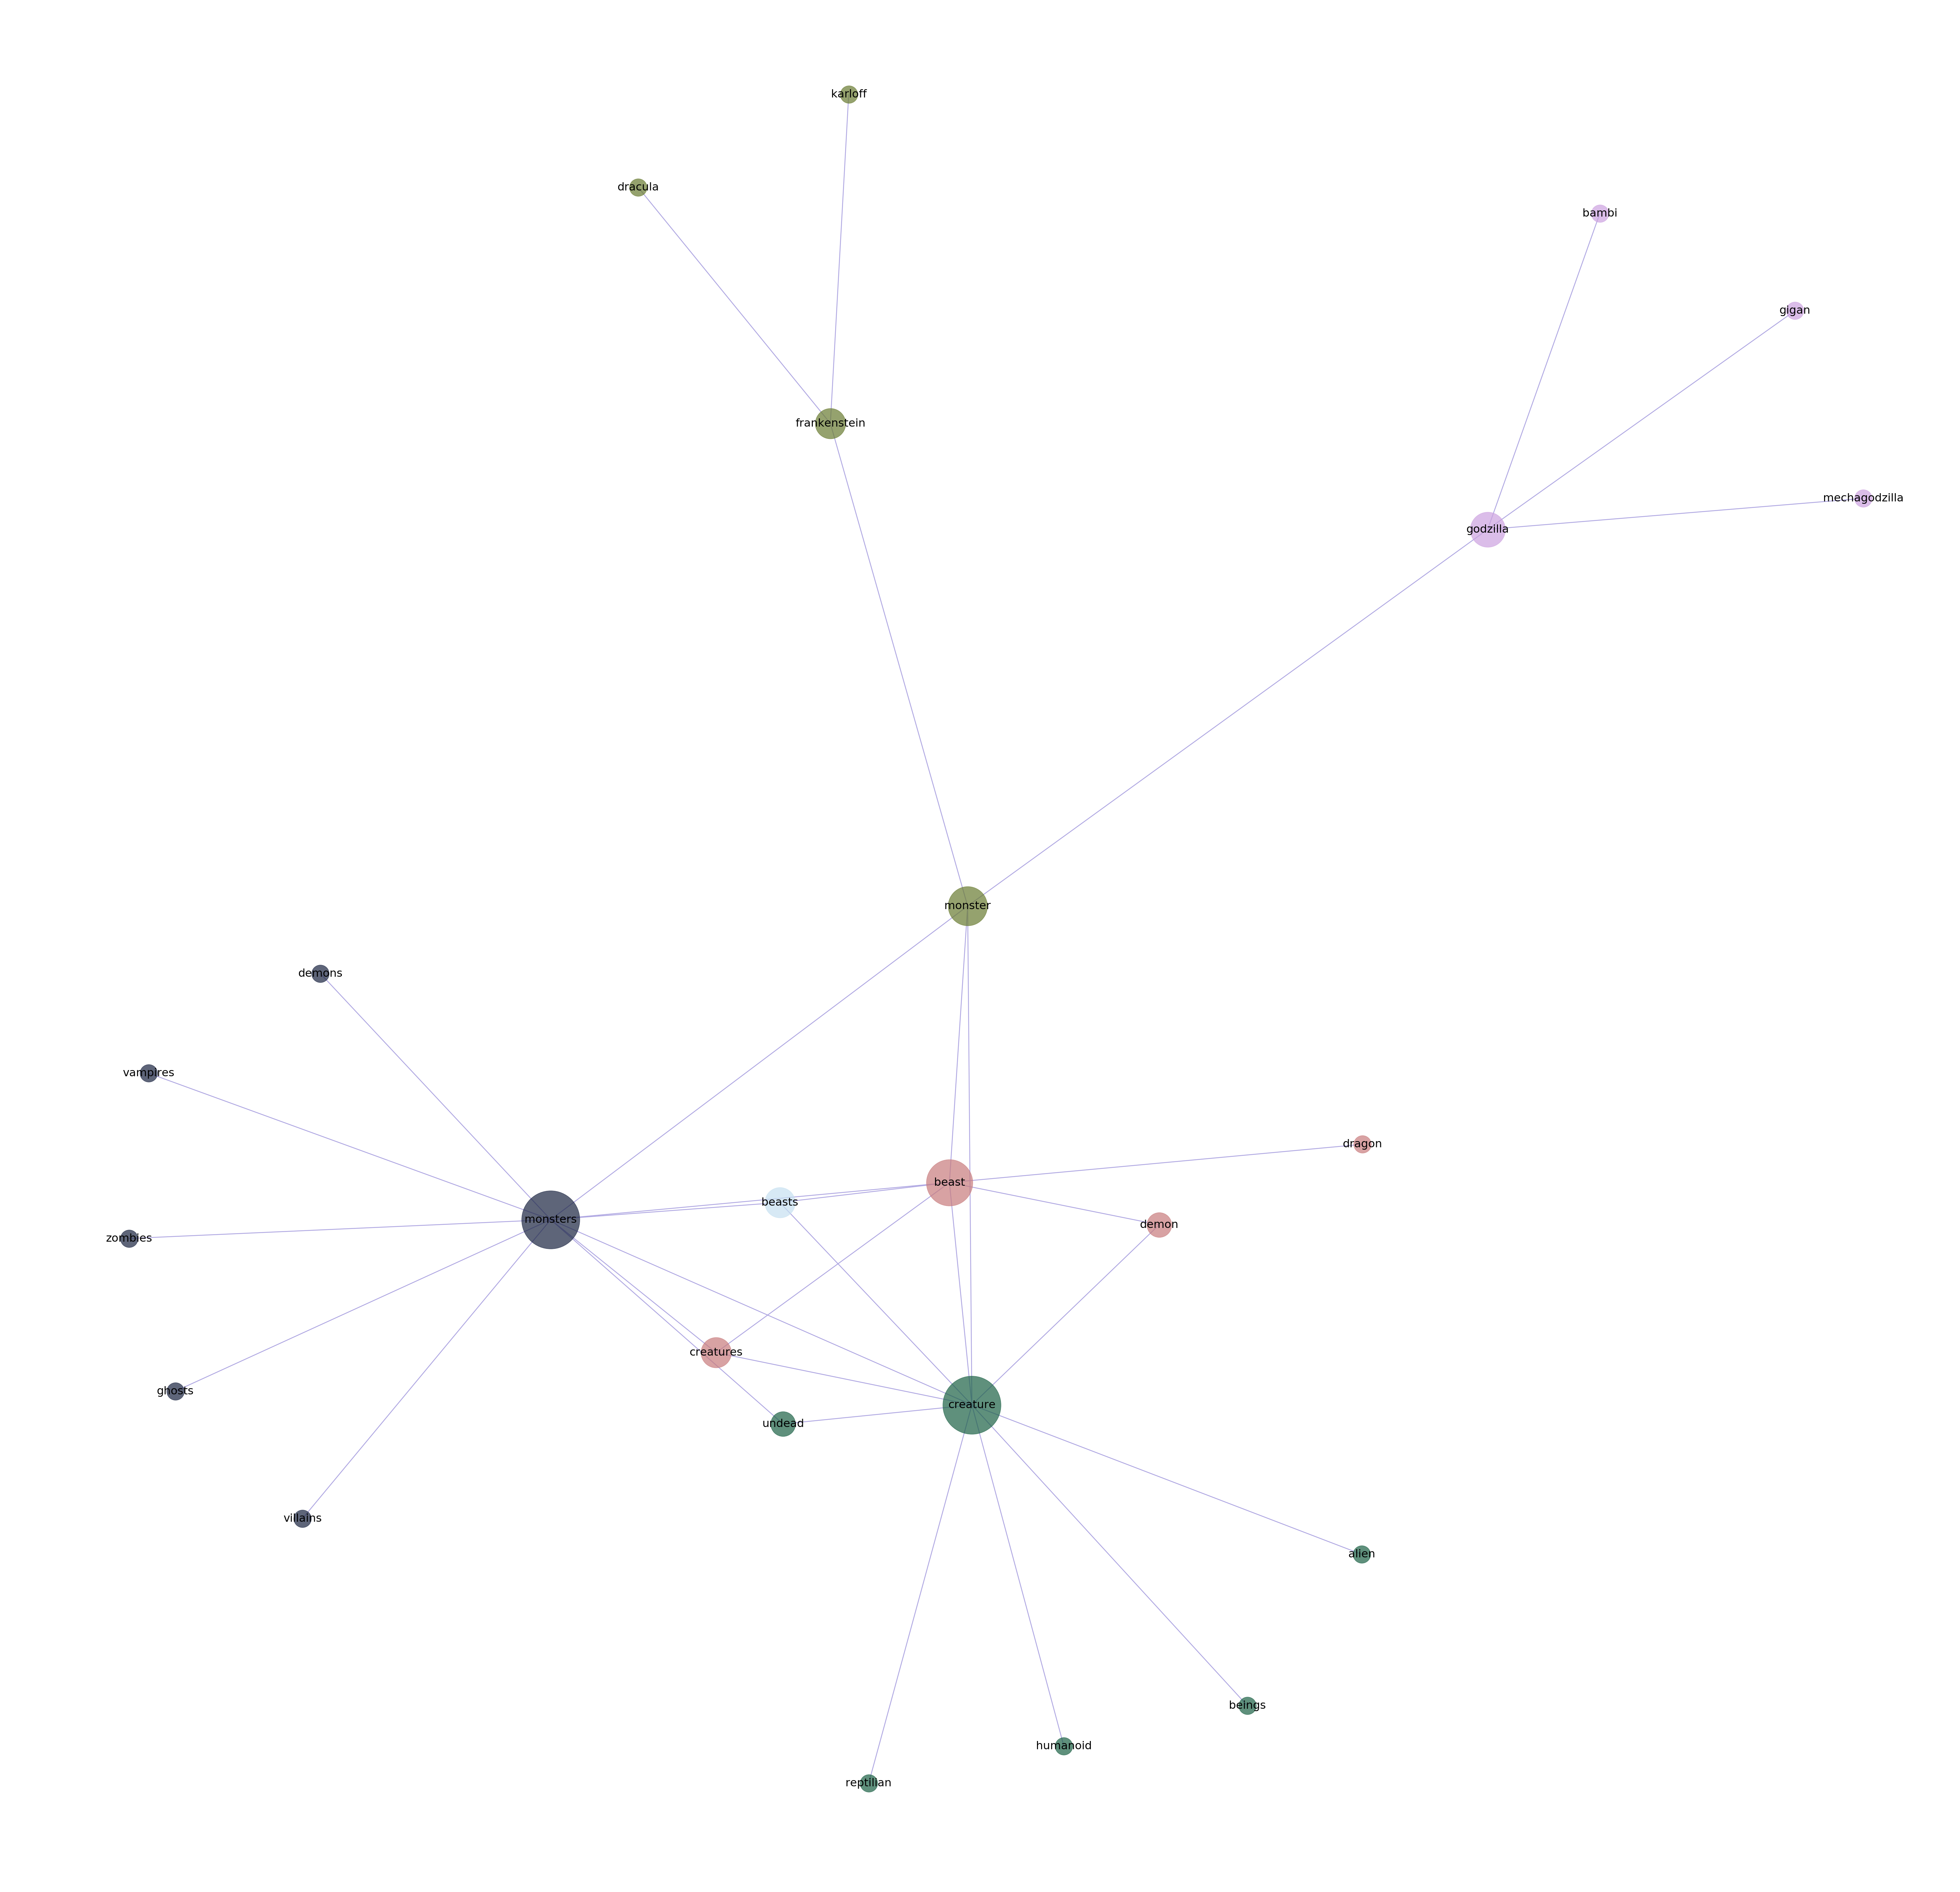

In [573]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('ggplot')

pos=nx.spring_layout(sem_field)

plt.figure(figsize=(40,40), dpi=180)
nx.draw_networkx_edges(sem_field, pos, edge_color='#AFA7E2')
nx.draw_networkx_labels(sem_field, pos, font_size=13)
plt.axis('off')
for word in sem_field.nodes():
    size = centr[word]*10000 # размер узла коррелирует с его degree centarality
    color = colors[word] # цвет узла обозначает принадлежность к какому-то сообществу
    nx.draw_networkx_nodes(sem_field, pos, nodelist=[word], node_color=color, alpha=0.7, node_size=size) 
# так как каждый раз первый узел выбирается рандомно, я решила, что полезно будет сохранять семантические карты
plt.savefig(f'{first_word}.png')
plt.show()

Первым узлом было слово "monster".
Видно разделение на 6 сообществ:
1. Лавандовый. Связанные с Годзилой (Бэмби - это участник короткометражного мультика "Бэмби встречается с Годзиллой")
2. Сине-зеленый. Sci-Fi.
3. Розовый. Сказки\волшебство?
4. Серый. Monsters - самый большой узел с популярными названиями отрицательных вымышленных персонажей.
5. Охра с зеленым. "Готические" монстры (и актеры их играющие).
6. Голубой. Выброс, который ни к чему не отнесся - beasts.